# Read the data

In [1]:
from nltk import word_tokenize, sent_tokenize
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import PyPDF2


In [2]:
pages = []
with open('ai-act-01.pdf', 'rb') as pdf_file:
    read_pdf = PyPDF2.PdfReader(pdf_file)
    for page in read_pdf.pages:
        pages.append(page.extract_text())

print(pages[0])

EN   EN 
 
 
 EUROPEAN  
COMMISSION   
Brussels, 21.4.2021  
COM(2021) 206 final  
2021/0106 (COD)  
 
Proposal for a  
REGULATION OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL  
LAYING DOWN HARMONISED RULES ON ARTIFICIAL INTELLIGENCE 
(ARTIFICIAL INTELLIGENCE ACT) AND AMENDING CERTAIN UNION 
LEGISLATIVE ACTS  
{SEC(2021)  167 final}  - {SWD(2021)  84 final}  - {SWD(2021)  85 final}   


In [3]:
print(pages[1])

EN 1  EN EXPLANATORY MEMORANDUM  
1. CONTEXT  OF THE  PROPOSAL  
1.1. Reasons for and objectives of the proposal  
This explanatory memorandum accompanies the proposal for a Regulation laying down 
harmonised rules on artificial intelligence (Artificial Intelligence Act). Artificial Intelligence 
(AI) is a fast evolving family of technologies that can bring a wide array of economic and 
societal benefits across the entire s pectrum of industries and social activities. By improving 
prediction, optimising operations and resource allocation, and personalising service delivery, 
the use of artificial intelligence can support socially and environmentally beneficial outcomes 
and pro vide key competitive advantages to companies and the European economy. Such 
action is especially needed in high -impact sectors, including climate change, environment and 
health, the public sector, finance, mobility, home affairs and agriculture. However, t he same 
elements and techniques that power the soci

In [4]:
sentences = []
for page in pages:
    sentences.extend(sent_tokenize(page))
number_of_words_in_sentence = [len(word_tokenize(sent)) for sent in sentences]

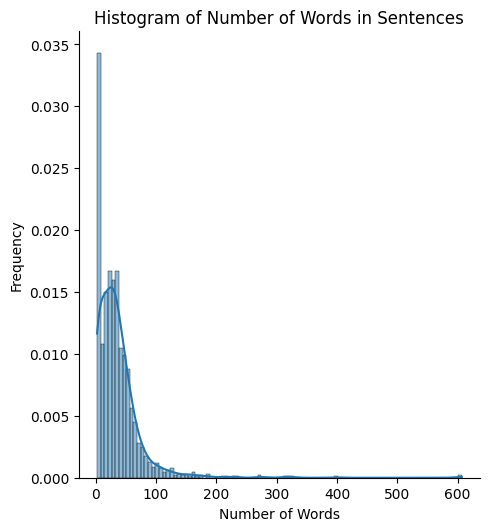

In [5]:
import seaborn as sns

sns.displot(number_of_words_in_sentence,  kde=True, stat="density")
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Sentences')
plt.show()


Wow! there is a sentence with more that 600 words! let's see what it is:

In [6]:
print(*list(zip(*np.unique(number_of_words_in_sentence, return_counts=True))), sep='\n')

(2, 218)
(3, 3)
(4, 5)
(5, 33)
(6, 23)
(7, 15)
(8, 21)
(9, 19)
(10, 20)
(11, 15)
(12, 12)
(13, 15)
(14, 19)
(15, 18)
(16, 33)
(17, 22)
(18, 23)
(19, 17)
(20, 26)
(21, 27)
(22, 19)
(23, 22)
(24, 34)
(25, 34)
(26, 19)
(27, 18)
(28, 30)
(29, 26)
(30, 29)
(31, 22)
(32, 23)
(33, 26)
(34, 29)
(35, 28)
(36, 25)
(37, 23)
(38, 24)
(39, 15)
(40, 24)
(41, 13)
(42, 18)
(43, 13)
(44, 14)
(45, 19)
(46, 11)
(47, 16)
(48, 19)
(49, 13)
(50, 14)
(51, 18)
(52, 15)
(53, 16)
(54, 9)
(55, 14)
(56, 9)
(57, 8)
(58, 12)
(59, 10)
(60, 7)
(61, 12)
(62, 3)
(63, 6)
(64, 9)
(65, 8)
(66, 8)
(67, 5)
(68, 6)
(69, 4)
(70, 5)
(71, 1)
(72, 5)
(73, 6)
(74, 5)
(75, 6)
(76, 2)
(77, 7)
(78, 1)
(79, 2)
(80, 5)
(81, 4)
(82, 3)
(83, 1)
(84, 3)
(85, 3)
(86, 2)
(87, 2)
(88, 1)
(89, 2)
(90, 1)
(91, 5)
(92, 1)
(93, 1)
(95, 1)
(96, 2)
(97, 3)
(98, 1)
(99, 1)
(100, 1)
(101, 2)
(102, 2)
(103, 2)
(104, 3)
(105, 1)
(106, 2)
(107, 2)
(108, 1)
(110, 1)
(111, 1)
(112, 2)
(114, 1)
(117, 2)
(119, 1)
(120, 2)
(121, 1)
(123, 1)
(124, 1)
(125, 

In [7]:
sentences[number_of_words_in_sentence.index(607)]

'EN 40  EN (3) ‘small -scale provider’ means a provider that is a micro or small enterprise within the \nmeaning of Commission Recommendation 2003/361/EC61; \n(4) ‘user’ means any natural or legal person, public authority, agency or other body \nusing an AI s ystem under its authority, except where the AI system is used in the \ncourse of a personal non -professional activity;  \n(5) ‘authorised representative’ means any natural or legal person established in the \nUnion who has received a written mandate from a provid er of an AI system to, \nrespectively, perform and carry out on its behalf the obligations and procedures \nestablished by this Regulation;  \n(6) ‘importer’ means any natural or legal person established in the Union that places on \nthe market or puts into service  an AI system that bears the name or trademark of a \nnatural or legal person established outside the Union;  \n(7) ‘distributor’ means any natural or legal person in the supply chain, other than the \nprovide

this is in page 40 of the pdf file.

it seems the website has better structure than the pdf file. lets start scraping the website.

# Extract the data from the website

in this part we should consider the following points:
1. the starting url is https://artificialintelligenceact.com/
1. there is no need to do DFS or BFS, we can just use the links in the main page to get to the other pages (other pages may have some links together but there is no need to do that).
1. there is some other links in the main page that are not related to the main content of the website, we should consider the links with this format `^https://artificialintelligenceact.com/title-[ivx]+/.+$` (that [ivx] is a roman number).
1. in the target pages we only consider a `<div>` with `class="container main-content"` and we should ignore the other parts of the page.

to keep this document tidy, I put the code in another file and import it here.
in this code:
- I use `requests` to get the content of the pages
- I use `BeautifulSoup` to parse the html content
- I use `re` to find the links with the above format
- I use `pickle` to save the data in a file (in case of any intruption in the process, I can continue from where I left)
- I use `time` to sleep between requests (to not put too much pressure on the server)
- The output is a list of lists, each list contains one page and the text of the page.


In [8]:
%reload_ext autoreload
%autoreload 2

In [9]:
from scrapper import Scrapper

In [10]:
scrapper = Scrapper()
scrapper.unvisited_links

['https://artificialintelligenceact.com/title-ii/article-5/',
 'https://artificialintelligenceact.com/title-i/article-1/',
 'https://artificialintelligenceact.com/title-i/article-2/',
 'https://artificialintelligenceact.com/title-i/article-3/',
 'https://artificialintelligenceact.com/title-i/article-4/',
 'https://artificialintelligenceact.com/title-ii/article-5/',
 'https://artificialintelligenceact.com/title-iii/chapter-1/article-6/',
 'https://artificialintelligenceact.com/title-iii/chapter-1/article-7/',
 'https://artificialintelligenceact.com/title-iii/chapter-2/article-8/',
 'https://artificialintelligenceact.com/title-iii/chapter-2/article-9/',
 'https://artificialintelligenceact.com/title-iii/chapter-2/article-10/',
 'https://artificialintelligenceact.com/title-iii/chapter-2/article-11/',
 'https://artificialintelligenceact.com/title-iii/chapter-2/article-12/',
 'https://artificialintelligenceact.com/title-iii/chapter-2/article-13/',
 'https://artificialintelligenceact.com/titl

In [11]:
scrapper.scrap()

page https://artificialintelligenceact.com/title-ii/article-5/ scrapped, 86 remaining, elapsed time: 3.1136038303375244
page https://artificialintelligenceact.com/title-i/article-1/ scrapped, 85 remaining, elapsed time: 4.118615627288818
page https://artificialintelligenceact.com/title-i/article-2/ scrapped, 84 remaining, elapsed time: 5.147934913635254
page https://artificialintelligenceact.com/title-i/article-3/ scrapped, 83 remaining, elapsed time: 6.181483268737793
page https://artificialintelligenceact.com/title-i/article-4/ scrapped, 82 remaining, elapsed time: 7.154689788818359
page https://artificialintelligenceact.com/title-ii/article-5/ scrapped, 81 remaining, elapsed time: 8.159490823745728
page https://artificialintelligenceact.com/title-iii/chapter-1/article-6/ scrapped, 80 remaining, elapsed time: 9.171422719955444
page https://artificialintelligenceact.com/title-iii/chapter-1/article-7/ scrapped, 79 remaining, elapsed time: 10.204690933227539
page https://artificialintel

In [12]:
scrapper.unvisited_links

[None]

In [13]:
scrapper.content[0]

['Home » Title II » Article 5',
 '\xa0',
 '1. The following artificial intelligence practices shall be prohibited:',
 '(a) the placing on the market, putting into service or use of an AI system that deploys subliminal techniques beyond a person’s consciousness in order to materially distort a person’s behaviour in a manner that causes or is likely to cause that person or another person physical or psychological harm;',
 '(b) the placing on the market, putting into service or use of an AI system that exploits any of the vulnerabilities of a specific group of persons due to their age, physical or mental disability, in order to materially distort the behaviour of a person pertaining to that group in a manner that causes or is likely to cause that person or another person physical or psychological harm;',
 '(c) the placing on the market, putting into service or use of AI systems by public authorities or on their behalf for the evaluation or classification of the trustworthiness of natural 

# Tokenization

In [14]:
sentences = []
for page in scrapper.content:
    for p in page:
        sentences.extend(sent_tokenize(p))
sentences

['Home » Title II » Article 5',
 '1.',
 'The following artificial intelligence practices shall be prohibited:',
 '(a) the placing on the market, putting into service or use of an AI system that deploys subliminal techniques beyond a person’s consciousness in order to materially distort a person’s behaviour in a manner that causes or is likely to cause that person or another person physical or psychological harm;',
 '(b) the placing on the market, putting into service or use of an AI system that exploits any of the vulnerabilities of a specific group of persons due to their age, physical or mental disability, in order to materially distort the behaviour of a person pertaining to that group in a manner that causes or is likely to cause that person or another person physical or psychological harm;',
 '(c) the placing on the market, putting into service or use of AI systems by public authorities or on their behalf for the evaluation or classification of the trustworthiness of natural perso

In [15]:
number_of_words_in_sentence = [len(word_tokenize(sent)) for sent in sentences]
np.unique(number_of_words_in_sentence, return_counts=True)

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  73,  74,  76,  77,  78,  80,  81,  82,  83,  85,
         86,  90,  93,  95, 119]),
 array([94,  9,  2,  4,  2, 32,  3,  9, 34,  2,  8, 48,  8, 11, 18, 19,  7,
         7, 15, 11,  9, 15, 11,  9, 11, 12, 12,  7, 10,  6,  2,  9, 15,  9,
        10,  9,  6,  5,  8, 10,  7,  9,  5,  3,  5,  6,  1,  7,  2,  4,  2,
         6,  6,  5,  5,  3,  4,  8,  2,  9,  2,  4,  6,  3,  3,  2,  4,  2,
         1,  3,  2,  1,  1,  1,  1,  1,  2,  1,  2,  1,  1,  2,  1]))

we have 94 sentences with two words! let's see what they are:

In [16]:
[s for s in sentences if len(word_tokenize(s)) == 2]

['1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '1.',
 '2.',
 '1.',
 '2.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '7.',
 '8.',
 '9.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '1.',
 '2.',
 '3.',
 '1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '3.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '3.',
 '4.',
 '1.',
 '2.',
 '2a.',
 '3.',
 '1.',
 '1a.',
 '2.',
 '1.',
 '2.',
 '1.',
 '2.',
 '1.',
 '1a.',
 '1b.',
 '2.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '1.',
 '2.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '1.',
 '2.',
 '3.',
 '4.',
 '5.',
 '6.',
 '7.',
 '8.']

Wow! since they are seperated with dot, tokenizer considers them as two sentences. let's ignore them for now.

In [17]:
sentences = [s for s in sentences if len(word_tokenize(s)) > 2]
number_of_words_in_sentence = [len(word_tokenize(sent)) for sent in sentences]
np.unique(number_of_words_in_sentence, return_counts=True)

(array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  73,  74,  76,  77,  78,  80,  81,  82,  83,  85,  86,
         90,  93,  95, 119]),
 array([ 9,  2,  4,  2, 32,  3,  9, 34,  2,  8, 48,  8, 11, 18, 19,  7,  7,
        15, 11,  9, 15, 11,  9, 11, 12, 12,  7, 10,  6,  2,  9, 15,  9, 10,
         9,  6,  5,  8, 10,  7,  9,  5,  3,  5,  6,  1,  7,  2,  4,  2,  6,
         6,  5,  5,  3,  4,  8,  2,  9,  2,  4,  6,  3,  3,  2,  4,  2,  1,
         3,  2,  1,  1,  1,  1,  1,  2,  1,  2,  1,  1,  2,  1]))

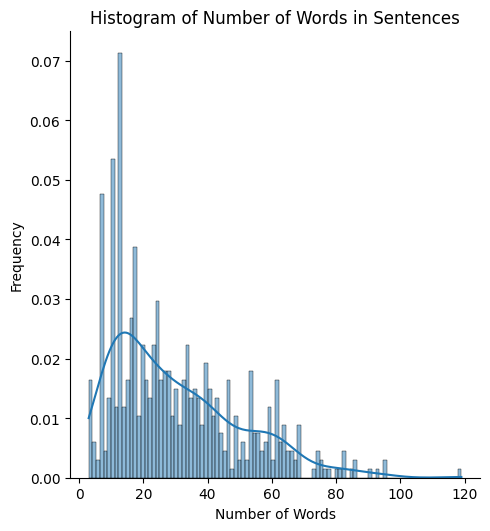

In [18]:
fig = sns.displot(number_of_words_in_sentence,  kde=True, stat="density", bins=100)
fig.set(xlabel='Number of Words', ylabel='Frequency', title = 'Histogram of Number of Words in Sentences')
plt.show()

Also, it is important for us to find the number of words in each page.
because the content of each page are somehow realted to each other, we use same data for training.

In [19]:
number_of_words_in_page = []
for page in scrapper.content:
    number_of_words_in_page.append(sum([len(word_tokenize(p)) for p in page]))
np.unique(number_of_words_in_page, return_counts=True)


(array([   7,   10,   13,   36,   44,   50,   51,   55,   56,   60,   66,
          70,   72,   76,   81,   84,   87,   88,   92,   93,   96,   98,
         100,  108,  117,  121,  134,  165,  168,  175,  179,  183,  206,
         218,  225,  233,  237,  253,  269,  271,  282,  308,  314,  336,
         373,  398,  424,  434,  445,  451,  458,  469,  489,  511,  679,
         708,  835,  976, 1940]),
 array([ 5, 14,  5,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,
         2,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  1,  1,  1,  1,  2,  1]))

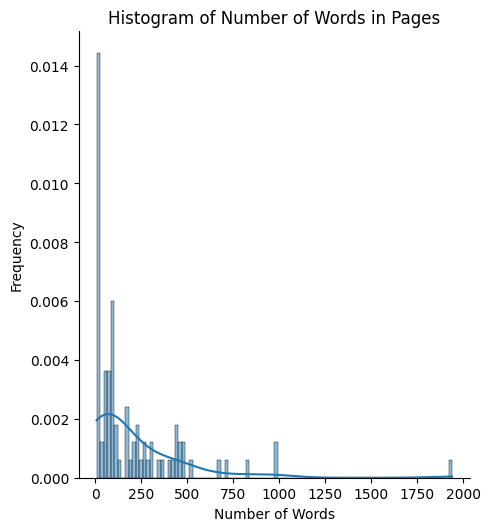

In [20]:
fig = sns.displot(number_of_words_in_page,  kde=True, stat="density", bins=100)
fig.set(xlabel='Number of Words', ylabel='Frequency', title = 'Histogram of Number of Words in Pages')
plt.show()

## word count

in this part we should consider the following points:
1. we should remove the punctuations
1. we should remove the stop words
1. we should remove the numbers
1. we should remove the words with length less than 3



In [21]:
# to see the stop words
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [22]:
def validate_word(word):
    word = word.lower()
    if word.isalpha() and word not in stopwords.words('english'):
        return word
    return None

In [23]:
all_words = []
for page in scrapper.content:
    for paragraph in page:
        for word in word_tokenize(paragraph):
            word = validate_word(word)
            if word:
                all_words.append(word)

np.unique(all_words, return_counts=True)

(array(['aa', 'ab', 'ability', ..., 'xii', 'year', 'years'], dtype='<U16'),
 array([ 1,  1,  2, ..., 11,  1,  4]))

In [24]:
words_count = list(zip(*np.unique(all_words, return_counts=True)))
words_count.sort(key=lambda x: x[1], reverse=True)
words_count

[('ai', 240),
 ('system', 236),
 ('shall', 188),
 ('article', 185),
 ('title', 162),
 ('systems', 117),
 ('iii', 108),
 ('chapter', 104),
 ('regulation', 93),
 ('home', 86),
 ('referred', 80),
 ('use', 77),
 ('data', 69),
 ('market', 64),
 ('conformity', 63),
 ('requirements', 63),
 ('paragraph', 54),
 ('technical', 52),
 ('purpose', 51),
 ('b', 49),
 ('set', 49),
 ('provider', 48),
 ('eu', 47),
 ('authorities', 46),
 ('authority', 46),
 ('means', 46),
 ('national', 46),
 ('service', 43),
 ('union', 43),
 ('competent', 41),
 ('following', 40),
 ('assessment', 39),
 ('documentation', 39),
 ('ep', 39),
 ('law', 38),
 ('intended', 36),
 ('agreed', 35),
 ('provisionally', 35),
 ('accordance', 34),
 ('artificial', 34),
 ('including', 34),
 ('intelligence', 34),
 ('persons', 34),
 ('providers', 33),
 ('annex', 32),
 ('appropriate', 32),
 ('c', 32),
 ('applicable', 31),
 ('member', 31),
 ('management', 30),
 ('may', 29),
 ('necessary', 29),
 ('risk', 29),
 ('identification', 28),
 ('level', 2

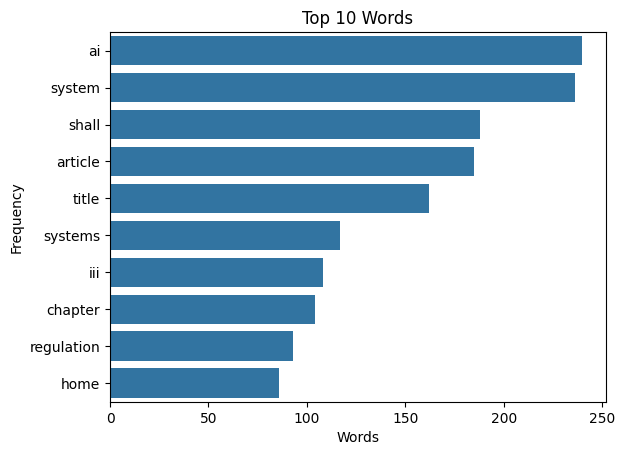

In [25]:
limit = 10
fig = sns.barplot(y=[w[0] for w in words_count[:limit]], x=[w[1] for w in words_count[:limit]])
fig.set(xlabel='Words', ylabel='Frequency', title = f'Top {limit} Words')
plt.show()

as we can see, there is a word "system" and "systems" in the list. we should consider them as one word. we can use `stemming` or `lemmatization` to do that. I use `LancasterStemmer` because it is more accurate. also, i can use `WordNetLemmatizer` but it is slower.

### lemmatization

In [26]:
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
all_words = [st.stem(w) for w in all_words]
all_words = [w for w in all_words if len(w) > 2]
np.unique(all_words, return_counts=True)


(array(['abl', 'abs', 'acc', 'acceiv', 'access', 'accompany', 'accord',
        'account', 'accredit', 'achiev', 'acknowledg', 'acquir',
        'acquisit', 'across', 'act', 'addit', 'address', 'adequ', 'admin',
        'adopt', 'adv', 'advers', 'affect', 'affix', 'aggreg', 'agr',
        'agree', 'aim', 'alleg', 'allow', 'already', 'also', 'alt',
        'amend', 'among', 'analys', 'annex', 'annot', 'anoma', 'anonym',
        'anoth', 'appl', 'apply', 'appoint', 'approach', 'appropry',
        'approv', 'area', 'arrang', 'art', 'artic', 'aspect', 'ass',
        'assess', 'assign', 'assist', 'assocy', 'assum', 'asyl', 'attack',
        'attempt', 'audio', 'audit', 'auth', 'autom', 'avail', 'avoid',
        'backup', 'bankrupt', 'bas', 'bear', 'becom', 'behalf', 'behavio',
        'behind', 'best', 'beyond', 'bia', 'bias', 'biomet', 'board',
        'body', 'bring', 'brought', 'built', 'burd', 'busy', 'button',
        'cap', 'capac', 'capt', 'car', 'carry', 'cas', 'categ', 'caus',
    

In [27]:
words_count = list(zip(*np.unique(all_words, return_counts=True)))
words_count.sort(key=lambda x: x[1], reverse=True)
words_count

[('system', 357),
 ('artic', 189),
 ('shal', 188),
 ('titl', 162),
 ('provid', 154),
 ('auth', 122),
 ('reg', 110),
 ('chapt', 104),
 ('hom', 86),
 ('nat', 80),
 ('refer', 80),
 ('person', 76),
 ('requir', 74),
 ('dat', 72),
 ('paragraph', 68),
 ('mean', 67),
 ('market', 65),
 ('act', 64),
 ('conform', 64),
 ('set', 63),
 ('techn', 62),
 ('purpos', 59),
 ('serv', 50),
 ('plac', 48),
 ('docu', 46),
 ('tak', 46),
 ('assess', 45),
 ('risk', 45),
 ('put', 44),
 ('follow', 42),
 ('compet', 41),
 ('inform', 41),
 ('not', 40),
 ('includ', 39),
 ('comply', 38),
 ('law', 38),
 ('accord', 37),
 ('body', 37),
 ('spec', 37),
 ('art', 36),
 ('intend', 36),
 ('man', 36),
 ('stat', 36),
 ('agree', 35),
 ('intellig', 34),
 ('appropry', 33),
 ('annex', 32),
 ('apply', 32),
 ('appl', 31),
 ('ens', 31),
 ('memb', 31),
 ('publ', 30),
 ('level', 29),
 ('may', 29),
 ('necess', 29),
 ('point', 29),
 ('account', 28),
 ('concern', 28),
 ('fin', 28),
 ('relev', 28),
 ('subject', 28),
 ('meas', 27),
 ('proc', 27

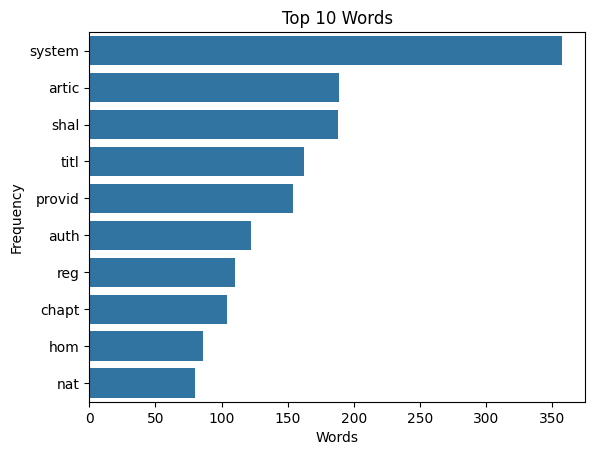

In [28]:
fig = sns.barplot(y=[w[0] for w in words_count[:limit]], x=[w[1] for w in words_count[:limit]])
fig.set(xlabel='Words', ylabel='Frequency', title = f'Top {limit} Words')
plt.show()

## Word Cloud

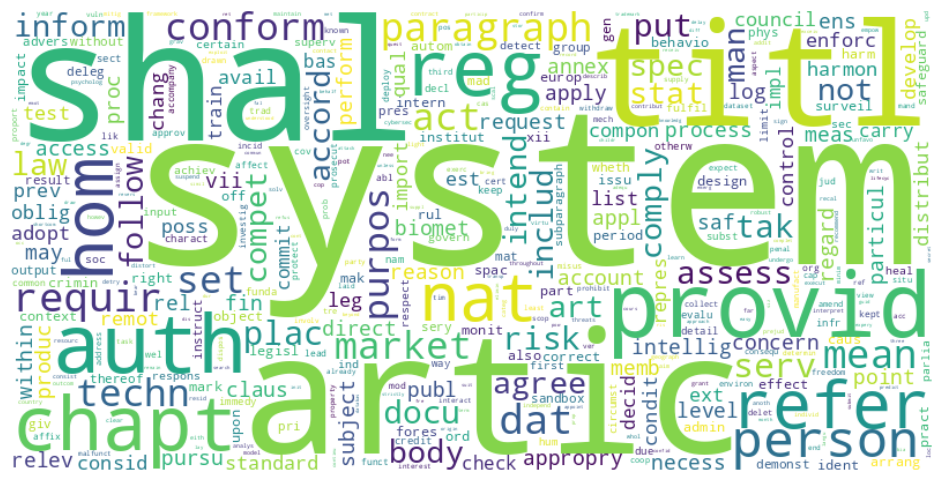

In [29]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=1000, width=800, height=400)
wc.generate_from_frequencies(dict(words_count))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- TODO1: I should try different lemmatisers and stemmers to see which one is better. right now we have words such "titl", "chapt", "dat" which sounds not real words.
- TODO2: create a word cloud for each page and see if there is any pattern in the words.
- TODO3: create words density for each page and see if there is any pattern in the words.
- TODO4: perform tf-idf on the words and see if there is any pattern in the words. (we can consider each page as a document)
- TODO5: use a pretrained word2vec model to plot the words in a 2D space.
- TODO6: create new dataset for text-completion and QA models.